In [1]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.proba.banana2d import Banana2D
from mcjax.mcmc.rwm import Rwm
from mcjax.util.mcmc import ess_geyer, normalized_autocorr
from mcjax.util.plot_2d import evaluate_on_grid_2d



In [2]:
# initialize jax RNG
key = jr.key(0)

### 2D Banana


In [3]:
# create an isotropic Gaussian
dist = Banana2D(noise_std = 0.3)
logdensity = dist.logdensity
logdensity_batch = jax.vmap(logdensity)

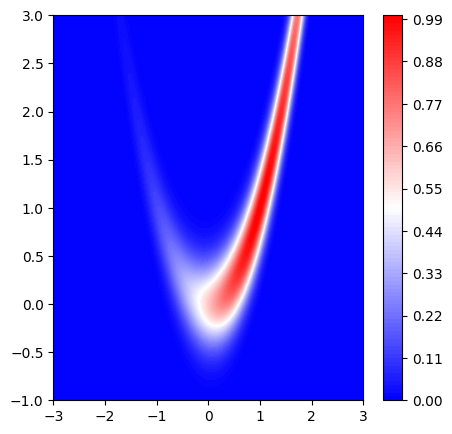

In [4]:
xmin, xmax = -3, 3
ymin, ymax = -1, 3
X, Y, Z = evaluate_on_grid_2d(
    func_batch=logdensity_batch,
    xlim=(xmin, xmax),
    ylim=(ymin, ymax),
    Nx=500,
    Ny=500
)

# plot the logpdf
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.colorbar()
plt.show()


### Run RWM

In [5]:
# random walk metropolis
mcmc = Rwm(logdensity=logdensity, step_size=0.1, cov=jnp.eye(2))

(-1.0, 3.0)

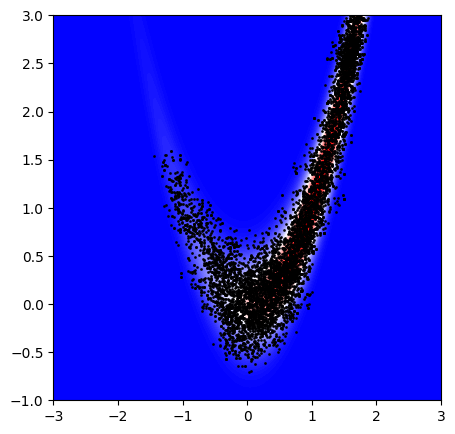

In [6]:
key, key_ = jr.split(key)
x_init = jnp.array([0., 0.])
state_init = mcmc.init_state(x_init)
mcmc_output = mcmc.run(key = key_, n_samples=10_000, state_init=state_init)
traj = mcmc_output.traj 
summary = mcmc_output.summary
samples = traj.x
# scatter plot of the samples
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.scatter(samples[:, 0], samples[:, 1], s=1, color='black', alpha=0.9)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

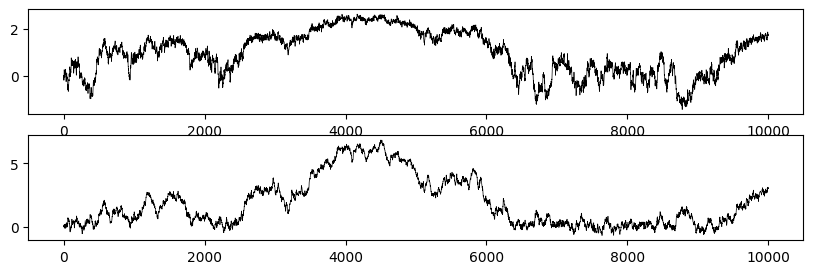

In [7]:
# plot x0 trajectory
plt.figure(figsize=(10, 3))
plt.subplot(2, 1, 1)
plt.plot(traj.x[:, 0], color='black', lw=0.5)
plt.subplot(2, 1, 2)
plt.plot(traj.x[:, 1], color='black', lw=0.5)

### Influence of the step size

In [8]:
# let's define a function that samples a trajectory -- small wrapper around the `sample_RWM` function
def sample_RWM(key, x0, step_size, n_steps):
    # define the RWM sampler
    mcmc = Rwm(logdensity=logdensity, step_size=step_size, cov=jnp.eye(2))
    # sample the trajectory
    state_init = mcmc.init_state(x0)
    mcmc_output = mcmc.run(key = key, n_samples=n_steps, state_init=state_init)
    return mcmc_output

sample_RWM = jax.jit(sample_RWM, static_argnums=(3,))

# let's define a function that samples a batch of trajectories
# for different step sizes so that we can study the influence of the step size
sample_RWM_batch = jax.vmap(sample_RWM, in_axes=(None, None, 0, None))
sample_RWM_batch = jax.jit(sample_RWM_batch, static_argnums=(3,))


In [9]:
x0 = jnp.array([0., 0.])
step_size = 0.1
n_steps = 1000_000
key, key_ = jr.split(key)
mcmc_output = sample_RWM(key_, x0, step_size, n_steps)
traj = mcmc_output.traj
summary = mcmc_output.summary

In [10]:
step_size_arr = np.linspace(0.01, 5., 500)
n_steps = 100_000
key, key_ = jr.split(key)
mcmc_output_batch = sample_RWM_batch(key_, x0, step_size_arr, n_steps)
traj_batch = mcmc_output_batch.traj
summary_batch = mcmc_output_batch.summary


Text(0.6, 0.6, 'Optimal step size: 3.10 \n Acceptance rate: 0.04')

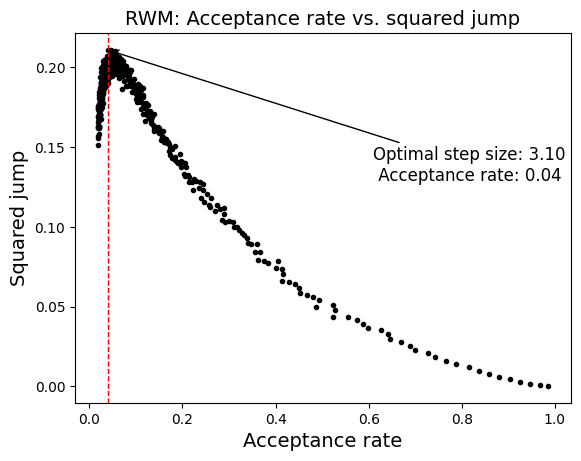

In [11]:
plt.plot(summary_batch.acceptance_rate, summary_batch.sq_jump, ".", color='black')
plt.xlabel("Acceptance rate", fontsize=14)
plt.ylabel("Squared jump", fontsize=14)
plt.title("RWM: Acceptance rate vs. squared jump", fontsize=14)

# find the optimal step size by maximizing the squared jump
index_opt = np.argmax(summary_batch.sq_jump)
optimal_step_size = step_size_arr[index_opt]
optimal_acceptance_rate = summary_batch.acceptance_rate[index_opt]

# draw vertical line at the optimal step size
plt.axvline(optimal_acceptance_rate, color='red', lw=1, ls='--')
# add an arrow pointing to the optimal step size with the value
plt.annotate(f"Optimal step size: {optimal_step_size:.2f} \n Acceptance rate: {optimal_acceptance_rate:.2f}",
                xy=(optimal_acceptance_rate, summary_batch.sq_jump[index_opt]),
                xytext=(0.6, 0.6),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='red', arrowstyle="->"),
                fontsize=12)

In [12]:
# now, let's tune by maximizing the effective sample size
ess_geyer_list = [ess_geyer(traj_batch.x[k,:,0]) for k in range(len(step_size_arr))]


Text(0.5, 1.0, 'RWM: Acceptance rate vs. ESS (Geyer)')

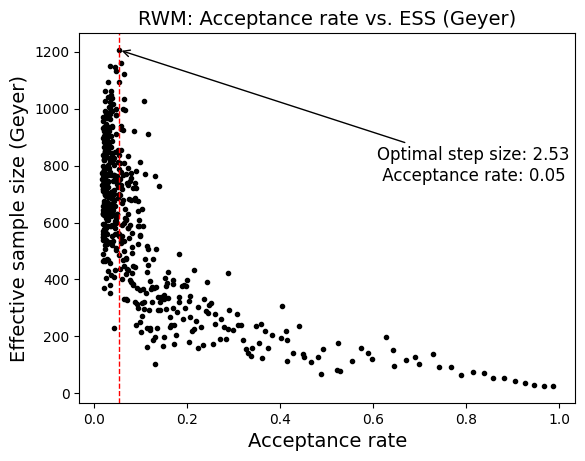

In [13]:
plt.plot(summary_batch.acceptance_rate, ess_geyer_list, ".", color='black')
plt.xlabel("Acceptance rate", fontsize=14)
plt.ylabel("Effective sample size (Geyer)", fontsize=14)

# find the optimal step size by maximizing the ESS
index_opt = np.argmax(ess_geyer_list)
optimal_step_size = step_size_arr[index_opt]
optimal_acceptance_rate = summary_batch.acceptance_rate[index_opt]

# draw vertical line at the optimal step size
plt.axvline(optimal_acceptance_rate, color='red', lw=1, ls='--')
# add an arrow pointing to the optimal step size with the value
plt.annotate(f"Optimal step size: {optimal_step_size:.2f} \n Acceptance rate: {optimal_acceptance_rate:.2f}",
                xy=(optimal_acceptance_rate, ess_geyer_list[index_opt]),
                xytext=(0.6, 0.6),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='red', arrowstyle="->"),
                fontsize=12)
plt.title("RWM: Acceptance rate vs. ESS (Geyer)", fontsize=14)

Text(0.5, 1.0, 'RWM: Autocorrelation function')

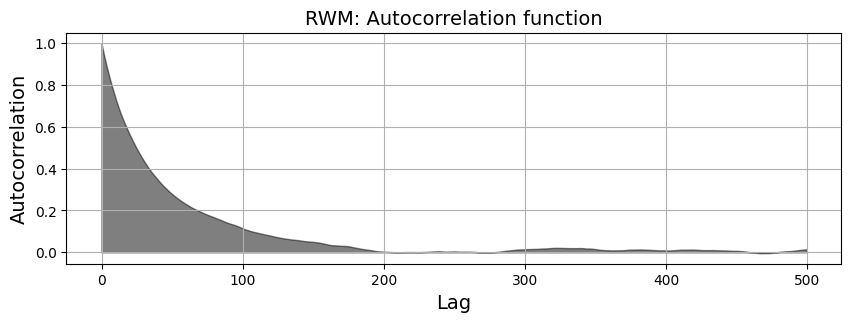

In [14]:
# plot the autocorrelation function at the optimal step size
trajectory = traj_batch.x[index_opt, :, 0]
autocorr = normalized_autocorr(trajectory)

# plot with fill_between
plt.figure(figsize=(10, 3))
max_lag = 500
plt.fill_between(np.arange(max_lag), [0 for _ in range(max_lag)], autocorr[:max_lag], color='black', alpha=0.5)
plt.xlabel("Lag", fontsize=14)
plt.ylabel("Autocorrelation", fontsize=14)
plt.grid()
plt.title("RWM: Autocorrelation function", fontsize=14)